# Varying the Hyperparameters

Typically the covariance function that we will use will have some parameters. For example, the squared-exponential covariance function in one dimension has following form

$$
k_y(x_p,x_q) = \sigma_f^2\exp\big(-\frac{1}{2l^2}(x_p-x_q)^2\big)+\sigma_n^2\delta_{pq}
$$

The covariance is denoted $k_y$ as it is for the noisy targets $y$ rather than for the underlying function $f$. Observe that the length-scale $l$, the signal variance $\sigma_f^2$ and the noise variance $\sigma_n^2$ can be varied. In general we call the free parameters *hyperparameters*.

In [1]:
import numpy as np

def exponential_cov(x1, x2, params, report_flag=False):
    x1 = np.array([x1]).reshape(-1)
    x2 = np.array([x2]).reshape(-1)
    sigma_f_ = params[0]
    l_ = params[1]
    if (report_flag):
        print("RBF Kernel with following parameter:")
        print("length scale: ",l_)
        print("sigma_f :", sigma_f_)   
    cov = sigma_f_**2 * np.exp( - 1. / (2.0 * l_**2) * np.subtract.outer(x1, x2)**2)

    return cov

In [2]:
# UNIT TEST exponential_cov
a = exponential_cov(np.array([1,2,3]).reshape(-1,1),np.array([2,3,5]).reshape(-1,1),[1.0,1.0,1.2],True)
b = exponential_cov(1,np.array([2,3,5]),[1.0,1.0,0.0],True)
c = exponential_cov([1,3],np.array([2,3,5]),[1.0,1.0,1.0],True)

RBF Kernel with following parameter:
length scale:  1.0
sigma_f : 1.0
RBF Kernel with following parameter:
length scale:  1.0
sigma_f : 1.0
RBF Kernel with following parameter:
length scale:  1.0
sigma_f : 1.0


Lets take the function for GP regression from the previous script and an additional plotting function for convenience to show the incluence of the different hyperparameters on the GP prediction. All coming example just hold for a GP with SE kernel.

In [3]:
from scipy.linalg import cho_solve, cholesky

def GP_regressior(X_,y_,covariance_function_,params_,x_star_):
    
    K = covariance_function_(X_,X_,params_)
    k_star = covariance_function_(x_star_,X_,params_).reshape(-1,1)
    k_star_trans = np.transpose(k_star)
    k_star_star = covariance_function_(x_star_,x_star_,params_).reshape(-1,1)
    
    L = np.linalg.cholesky(K + params_[2]**2* np.eye(K.shape[0])) # Line 2
    
    #alpha = cho_solve((L, True), y_) # line 3
    temp = np.linalg.lstsq(L,y_,rcond=-1)[0]
    alpha = np.linalg.lstsq(np.transpose(L),temp,rcond=-1)[0] # line 3
    
    f_star = k_star_trans.dot(alpha)  # line 4
    v = np.linalg.lstsq(L,k_star,rcond=-1)[0] # line 5
    V_star = k_star_star - np.dot(np.transpose(v),v) #line 6
    f_star = f_star.astype(np.float64)
    V_star = V_star.astype(np.float64)
    return f_star, V_star

In [4]:
# UNIT TEST gaussianProcess_regressior
GP_regressior(np.array([0.1,0.5,2]),np.array([1,3,6]),exponential_cov,[1.0,1.0,1.0],1)

(array([2.56598176]), array([[0.45868434]]))

In [5]:
def plot_GP_regressior_output(f_hat_star_, V_star_,x_,y_,X_star_,params_,imName):
    if (np.amin(V_star_) > 0):
        V_star_ = V_star_.astype(np.float64)
        f_hat_star_lowerBound = f_hat_star_ - 2 * np.sqrt(V_star_.reshape(-1))
        f_hat_star_upperBound = f_hat_star_ + 2 * np.sqrt(V_star_.reshape(-1))
    else:
        print("At least one value of the variances is negative, we won't plot the confidence Intervalls")
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(x_,y_,s=50)


    ax.plot(X_star_,f_hat_star_, label="mean prediction")
    ax.grid()
    ax.set_ylabel("f*")
    ax.set_xlabel("x")
    ax.set_title(("GP Regressior, sigma_a={}, length-scale={}, sigma_n={}").format(params_[0],params_[1],params_[2]))
    
    if (np.amin(V_star_) > 0):
        ax.plot(X_star_,f_hat_star_lowerBound,c='r',label='95% Confidence Interval')
        ax.plot(X_star_,f_hat_star_upperBound,c='r')
        ax.fill_between(X_star.reshape(-1),
                    f_hat_star_lowerBound.reshape(-1), 
                    f_hat_star_upperBound.reshape(-1),
                    alpha=0.2, color='y')
    ax.legend(loc=0)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=10)
        

Lets create example training data $x$ and $y$ by a GP Prior.

In [6]:
np.random.seed(17)
x = (np.random.rand(4) * 2 - 1) * 5
cov = exponential_cov(x,x,[0.43,1.0,0.025])
# draw samples from the prior
L = np.linalg.cholesky(cov + 1e-6 * np.eye(4))
y = np.dot(L, np.random.normal(size=(4,1))) * 2
X_star = np.linspace(-10,10,100)

In [7]:
y

array([[0.53655641],
       [1.01627309],
       [1.00372574],
       [1.88049337]])

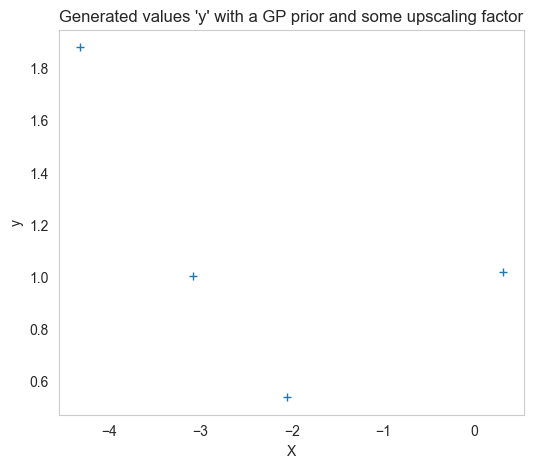

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 5))
ax.set_ylabel("y")
ax.set_xlabel("X")
ax.set_title("Generated values 'y' with a GP prior and some upscaling factor")
ax.grid()
ax.plot(x,y, '+')

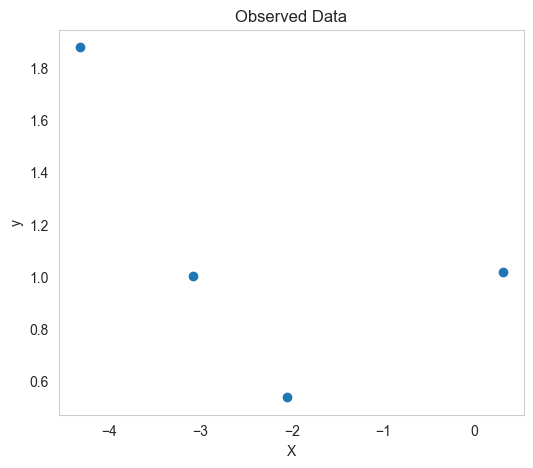

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_ylabel("y")
ax.set_xlabel("X")
ax.set_title("Observed Data")
ax.grid()
ax.scatter(x,y)

__Effect of $l$ on covariance matrix__

$l > 1.0$ has the effect that the exponent will increase. Therefore the effect of the distances of the input vectors decreases which means that even far points will have a higher correlation. And this means that the model gets less wiggly. On the other side, when $l < 1.0$ the exponent decreases and only points which are close to each other will correlate. This model will then be very wiggly. See the effect on the covariance matrix below

In [10]:
l = 0.5
X = np.array([1,2,3])
print("l = 0.5 ")
print(exponential_cov(X,X,[1.0,l,0.0],False))
l = 5.0
print("\n")
print("l = 5.0")
print(exponential_cov(X,X,[1.0,l,0.0],False))

l = 0.5 
[[1.00000000e+00 1.35335283e-01 3.35462628e-04]
 [1.35335283e-01 1.00000000e+00 1.35335283e-01]
 [3.35462628e-04 1.35335283e-01 1.00000000e+00]]


l = 5.0
[[1.         0.98019867 0.92311635]
 [0.98019867 1.         0.98019867]
 [0.92311635 0.98019867 1.        ]]


__Effect of $l$ on GP prediction__

The upper GP prediction is done with a $l=0.5$ and the graph below with $l = 5.0$. With the higher length-scale the confidence intervall even around unseen regions shrinks a lot because there's also on far points a high correlation. On the other hand with a lower $l$ the confidence intervall around unseen region is increasing very fast.

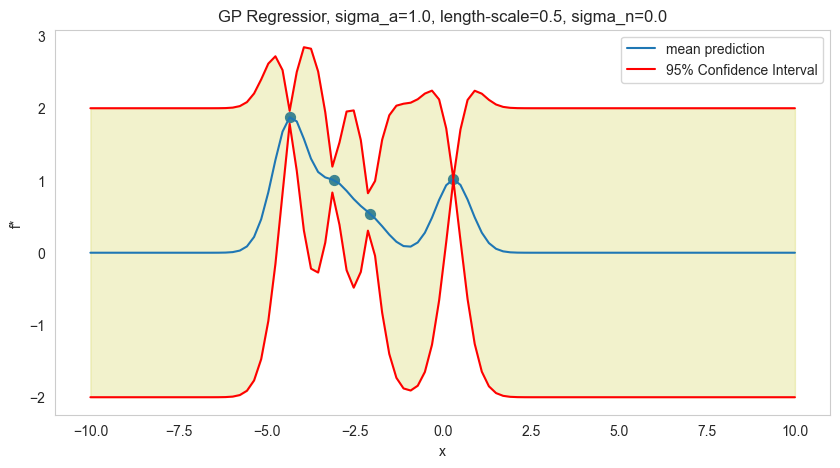

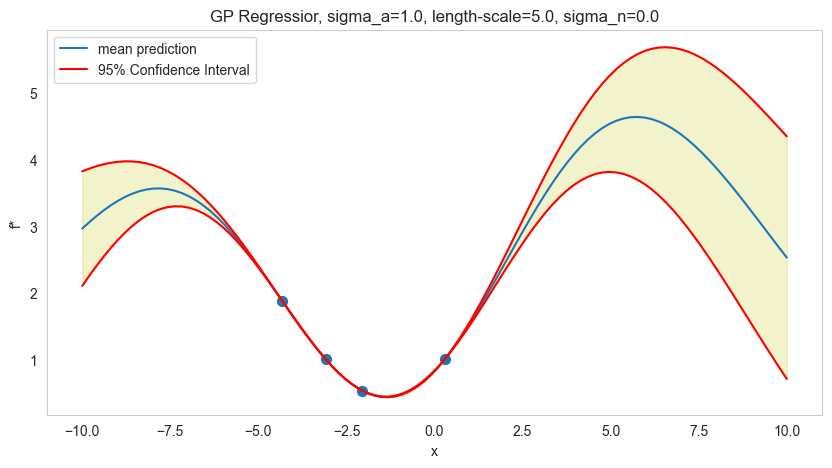

In [11]:
params1 = [1.0,0.5,0.0]
predictions = [GP_regressior(x,y,exponential_cov,params1,x_star) for x_star in X_star]
predictions = np.array([predictions], ).reshape(X_star.shape[0],2)
f_hat_star1 = predictions[:,0]
V_star1 = predictions[:,1]
params2 = [1.0,5.0,0.0]
predictions = [GP_regressior(x,y,exponential_cov,params2,x_star) for x_star in X_star]
predictions = np.array([predictions], ).reshape(X_star.shape[0],2)
f_hat_star2 = predictions[:,0]
V_star2 = predictions[:,1]
plot_GP_regressior_output(f_hat_star1,V_star1,x,y,X_star,params1,'plotVaryingHyperparametersLengthScaleLow')
plot_GP_regressior_output(f_hat_star2,V_star2,x,y,X_star,params2,'plotVaryingHyperparametersLengthScaleHigh')

__Effect of $\sigma_a$__

$\sigma_a$ is scalling up or down (depending on $\sigma_a > 0$ or $\sigma_a < 0$) all numbers in the covariance matrix in the same way.

In [12]:
sigma_a = 0.5
X = np.array([1,2,3])
print("sigma_a = 0.5 ")
print(exponential_cov(X,X,[sigma_a,1.0,0.0],False))
sigma_a = 5.0
print("\n")
print("sigma_a = 5.0")
print(exponential_cov(X,X,[sigma_a,1.0,0.0],False))

sigma_a = 0.5 
[[0.25       0.15163266 0.03383382]
 [0.15163266 0.25       0.15163266]
 [0.03383382 0.15163266 0.25      ]]


sigma_a = 5.0
[[25.         15.16326649  3.38338208]
 [15.16326649 25.         15.16326649]
 [ 3.38338208 15.16326649 25.        ]]


__Effect of $\sigma_a$ on GP prediction__

The upper GP prediction is done with a $\sigma_a=0.5$ and the graph below with $\sigma_a = 5.0$. Consider the different scales of the graphs. With a higher $\sigma_a$ in general the confidence intervall band increases. We're more uncertain about predictions especially when there's no training data located. In other words the variance on every unseen location increases. With a lower $\sigma_a$ value the confidence interval in general shrinks also around training data. The factor has to be seen as up- or down-scaling of the confidence of predictions. It has no direct influence on correlation between single data because they're scaled all in the same manner.

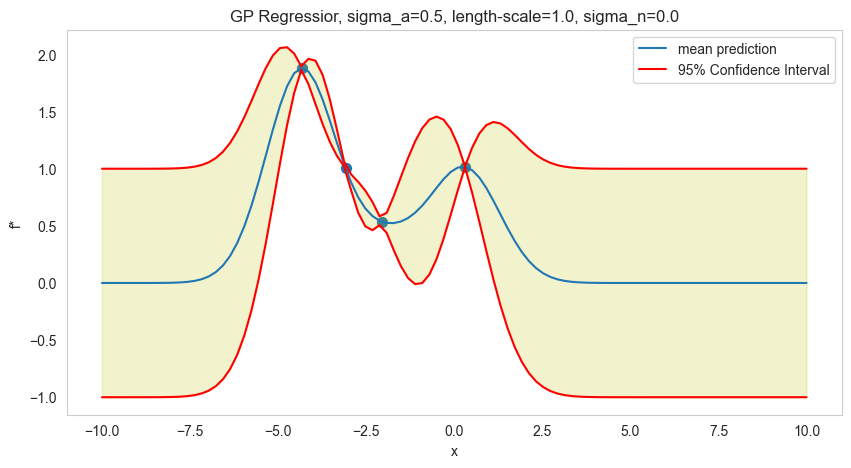

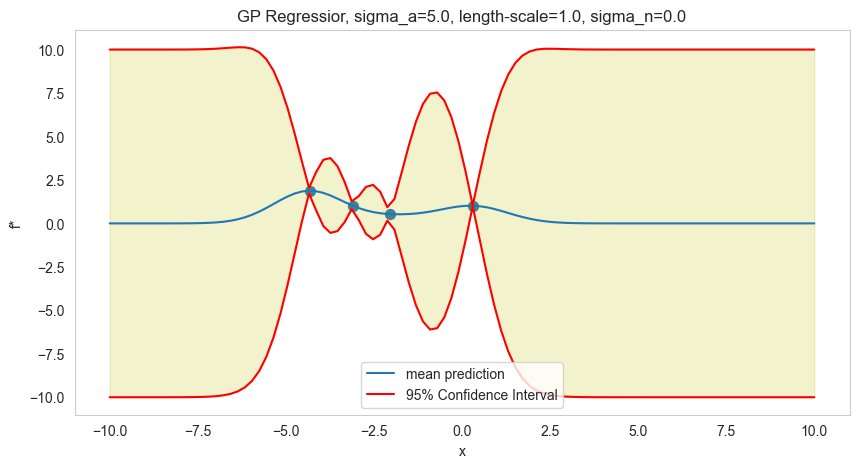

In [13]:
params1 = [0.5,1.0,0.0]
predictions = [GP_regressior(x,y,exponential_cov,params1,x_star) for x_star in X_star]
predictions = np.array([predictions], ).reshape(X_star.shape[0],2)
f_hat_star1 = predictions[:,0]
V_star1 = predictions[:,1]
params2 = [5.0,1.0,0.0]
predictions = [GP_regressior(x,y,exponential_cov,params2,x_star) for x_star in X_star]
predictions = np.array([predictions], ).reshape(X_star.shape[0],2)
f_hat_star2 = predictions[:,0]
V_star2 = predictions[:,1]
plot_GP_regressior_output(f_hat_star1,V_star1,x,y,X_star,params1,'plotVaryingHyperparametersSignalVarianceLow')
plot_GP_regressior_output(f_hat_star2,V_star2,x,y,X_star,params2,'plotVaryingHyperparametersSignalVarianceHigh')

__Effect of $\sigma_n$ on covariance matrix__

$\sigma_n$ is the noise value of our training data. The value normally has no influence in a SE- Kernel. How ever it is included in Rasmussen (2.31) as adding factor and multiplied with a Kroenecker delta. For implementation simplicity we consider the factor when calculating the $\mathbf{K}$ matrix in the "GP_regressior" function. In other frameworks the "WhiteKernel" has to be added to any other kernel to add white noise. This kernel holds in general the $\sigma_n$ value and adds to every diagonal element of the $\mathbf{K}$ matrix the noise. Therefore no effect on the covariance matrix.

In [14]:
sigma_n = 0.5
X = np.array([1,2,3])
print("sigma_n = 0.5 ")
print(exponential_cov(X,X,[1.0,1.0,sigma_n],False))
sigma_n = 5.0
print("\n")
print("sigma_n = 5.0")
print(exponential_cov(X,X,[1.0,1.0,sigma_n],False))

sigma_n = 0.5 
[[1.         0.60653066 0.13533528]
 [0.60653066 1.         0.60653066]
 [0.13533528 0.60653066 1.        ]]


sigma_n = 5.0
[[1.         0.60653066 0.13533528]
 [0.60653066 1.         0.60653066]
 [0.13533528 0.60653066 1.        ]]


__Effect of $\sigma_n$ on GP prediction__

The upper GP prediction is done with a $\sigma_n=0.5$ and the graph below with $\sigma_n = 5.0$. By adding noise to our model we state that we don't have direct access to the data. In other words the model is even unvertain around seen points. The confidence band increases around seen data.

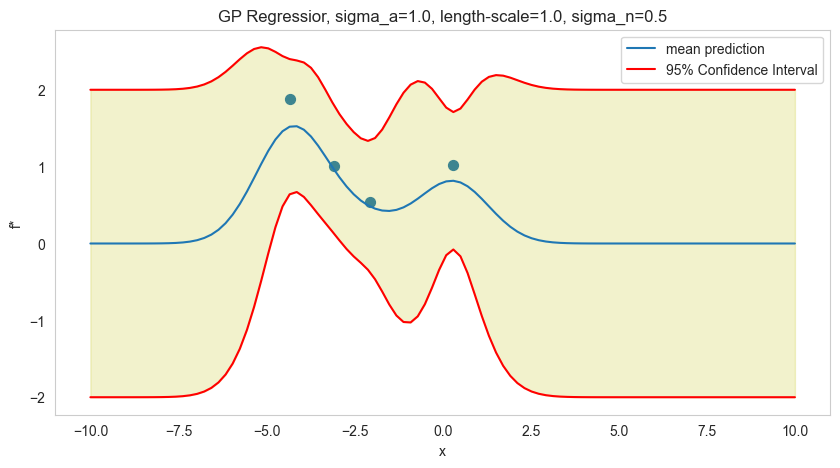

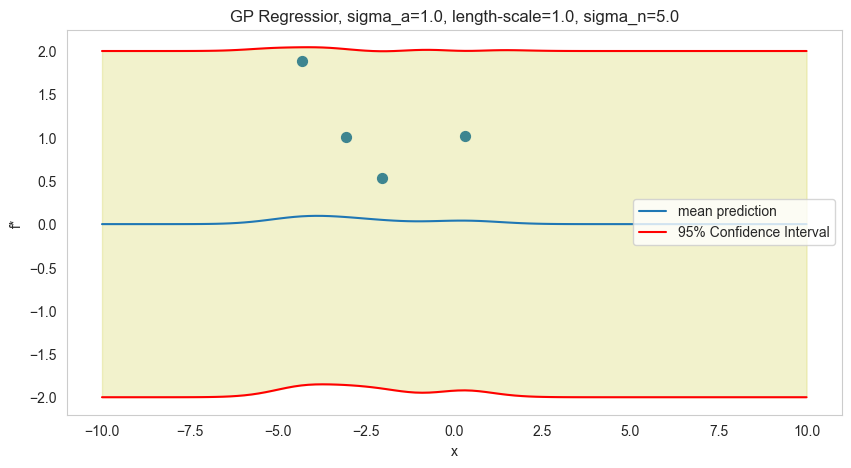

In [15]:
params1 = [1.0,1.0,0.5]
predictions = [GP_regressior(x,y,exponential_cov, params1,x_star) for x_star in X_star]
predictions = np.array([predictions], ).reshape(X_star.shape[0],2)
f_hat_star1 = predictions[:,0]
V_star1 = predictions[:,1]
params2 = [1.0,1.0,5.0]
predictions = [GP_regressior(x,y,exponential_cov, params2,x_star) for x_star in X_star]
predictions = np.array([predictions], ).reshape(X_star.shape[0],2)
f_hat_star2 = predictions[:,0]
V_star2 = predictions[:,1]
plot_GP_regressior_output(f_hat_star1,V_star1,x,y,X_star,params1,'plotVaryingHyperparametersNoiseVarianceLow')
plot_GP_regressior_output(f_hat_star2,V_star2,x,y,X_star, params2,'plotVaryingHyperparametersNoiseVarianceHigh')

This effect can also been illustrated when we have a look at the predicted variance of a seen point by variing the noise factor:

In [16]:
print("The predicted variance of a training input with sigma_n = 0.0 is: ",
      GP_regressior(x,y,exponential_cov,[1.0,1.0,0.0],x[1])[1])
print("The predicted variance of a training input with sigma_n = 5.0 is: ",
      GP_regressior(x,y,exponential_cov,[1.0,1.0,5.0],x[1])[1])

The predicted variance of a training input with sigma_n = 0.0 is:  [[-5.10702591e-15]]
The predicted variance of a training input with sigma_n = 5.0 is:  [[0.96140229]]


We will have a look at an example with more training data and vary the hyperparameters.

In [17]:
np.random.seed(17)
x = (np.random.rand(20) * 2 - 1) * 5
x = x.reshape(-1,1)
cov = exponential_cov(x,x,[0.43,1.0,0.025])
# draw samples from the prior
L = np.linalg.cholesky(cov + 1e-6*np.eye(20))
y = np.dot(L, np.random.normal(size=(20,1))) * 2

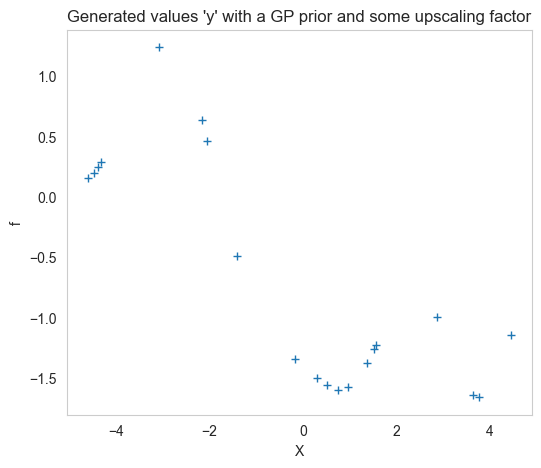

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 5))
ax.set_ylabel("f")
ax.set_xlabel("X")
ax.set_title("Generated values 'y' with a GP prior and some upscaling factor")
ax.grid()
ax.plot(x,y, '+')

In [19]:
X_star = np.linspace(-10.0,10.0,100)

In [20]:
# First: sigma_a; Second: Length-scale; Third: sigma_n Noise 
params1 = [1.0,3.0,1.5]

In [21]:
predictions = [GP_regressior(x,y,exponential_cov,params1,x_star) for x_star in X_star]
predictions = np.array([predictions], ).reshape(X_star.shape[0],2)
f_hat_star1 = predictions[:,0]
V_star1 = predictions[:,1]
print("Max V_star: ",np.amax(V_star1))
print("Min V_star: ",np.amin(V_star1))

Max V_star:  0.9870501180268455
Min V_star:  0.18937287222361443


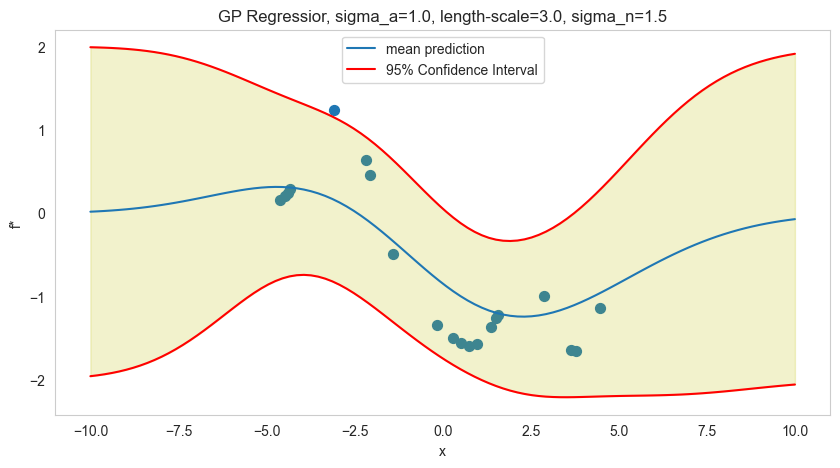

In [22]:
 plot_GP_regressior_output(f_hat_star1,V_star1,x,y,X_star,params1,False)

In [23]:
# First: sigma_a; Second: Length-scale; Third: sigma_n Noise 
params2 = [2.5,0.255,0.1]

In [24]:
predictions = [GP_regressior(x,y,exponential_cov,params2,x_star) for x_star in X_star]
predictions = np.array([predictions], ).reshape(X_star.shape[0],2)
f_hat_star2 = predictions[:,0]
V_star2 = predictions[:,1]
print("Max V_star: ",np.amax(V_star2))
print("Min V_star: ",np.amin(V_star2))

Max V_star:  6.25
Min V_star:  0.006135213201257095


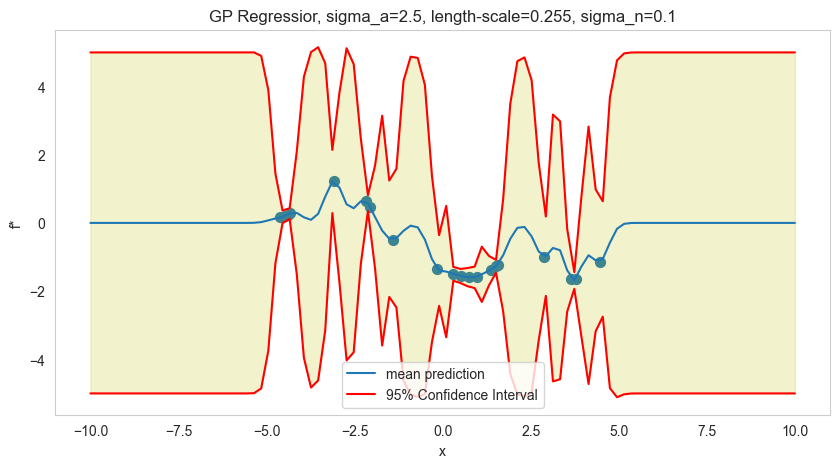

In [25]:
 plot_GP_regressior_output(f_hat_star2,V_star2,x,y,X_star,params2,False)

In [26]:
# First: sigma_a; Second: Length-scale; Third: sigma_n Noise 
params3 = [1.0,1.5,0.3]

In [27]:
predictions = [GP_regressior(x,y,exponential_cov,params3,x_star) for x_star in X_star]
predictions = np.array([predictions], ).reshape(X_star.shape[0],2)
f_hat_star3 = predictions[:,0]
V_star3 = predictions[:,1]
print("Max V_star: ",np.amax(V_star3))
print("Min V_star: ",np.amin(V_star3))

Max V_star:  0.9999970101735445
Min V_star:  0.015794487453628436


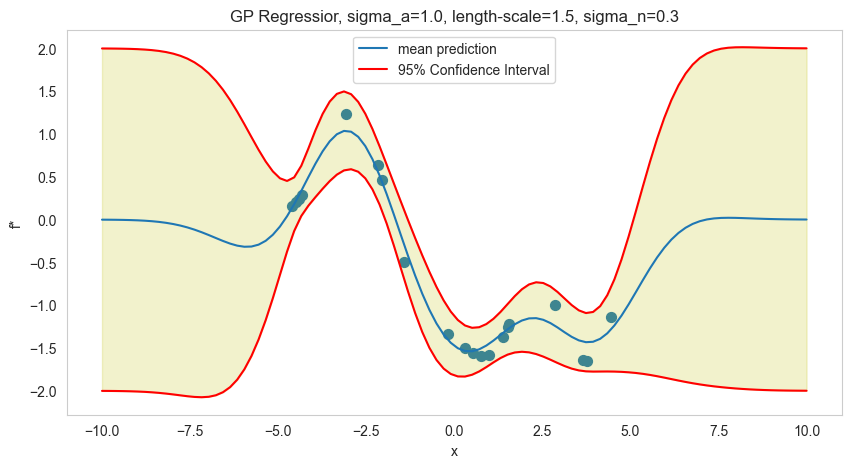

In [28]:
 plot_GP_regressior_output(f_hat_star3,V_star3,x,y,X_star,params3,False)

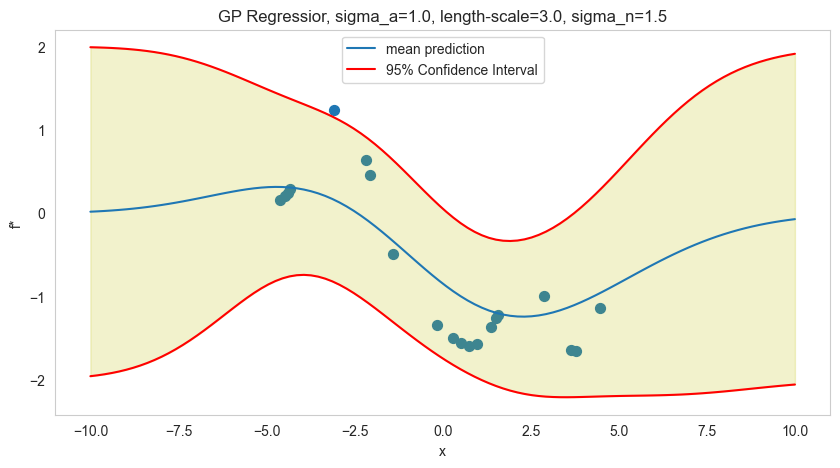

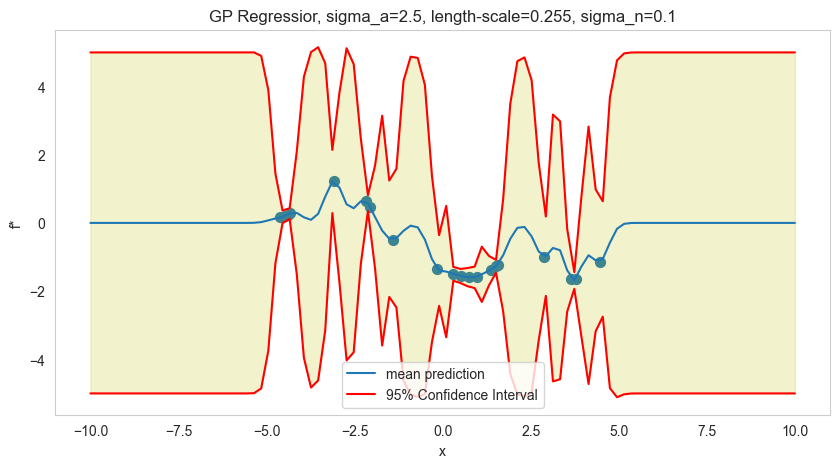

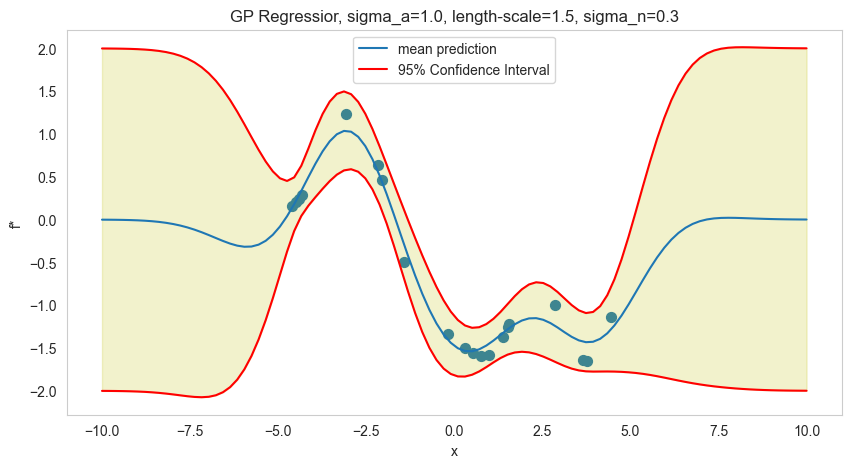

In [29]:
plot_GP_regressior_output(f_hat_star1,V_star1,x,y,X_star,params1,False)
plot_GP_regressior_output(f_hat_star2,V_star2,x,y,X_star,params2,False)
plot_GP_regressior_output(f_hat_star3,V_star3,x,y,X_star,params3,False)

Which model describes now our data best? We have to do model selection and find the optimal hyperparameters. This have to be done by optimizing the log marginal likelihood. When deriving the posterior of a GP we saw the marginal likelihood as

$$
f(\mathbf{y} \mid X)  = \int f(\mathbf{y} \mid \mathbf{f}, X)f(\mathbf{f}\mid X)d\mathbf{f}
$$

Explained in words this gives us the probability of $y$ given $X$. By maximizing this value by vary the hyperparameter we will find appropriate models. This function can have several maxima and we need search-algorithms to find the best model.

$$
\begin{equation}
\begin{split}
    f(\mathbf{y} \mid X) 
    & \propto 
    \int
        \exp\left(
        -\frac{1}{2}
        (\mathbf{f}-\mathbf{y})^T
        \sigma_n^{-2}\mathrm{I}
        (\mathbf{f}-\mathbf{y})
        \right) 
        \exp\left(
        - \frac{1}{2}
        (\mathbf{f}-0)^T
        \mathbf{K}^{-1}
        (\mathbf{f}-0)\right)
        d\mathbf{f}\\
    & \propto
        \int
        \exp\left(
        -\frac{1}{2}
        \Big(
            \mathbf{f}^T\big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{f}
            -2\mathbf{f}^T\big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}
            +\mathbf{y}^T\big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}
        \Big)
        - \frac{1}{2}\mathbf{f}^T\mathbf{K}^{-1}\mathbf{f}\right)
        d\mathbf{f}\\
\end{split}
\end{equation}
$$

$\mathbf{y}^T\big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}$ is not depending on $\mathbf{f}$ so we can take it out of the integral.

$$
\begin{equation}
\begin{split}
    f(\mathbf{y} \mid X) 
    & \propto
        \mathbf{y}^T\big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}
        \int
        \exp
        \left(
            \mathbf{f}^T\big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{f}
            -2\mathbf{f}^T\big(\sigma_n^2\mathrm{I}\big)^{-1}y
            +\mathbf{f}^T\mathbf{K}^{-1}\mathbf{f}
        \right)
        d\mathbf{f}\\
    & \propto
    \mathbf{y}^T\big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}
    \int
        \exp\left(
            \mathbf{f}^T\big(\sigma_n^2\mathrm{I}+\mathbf{K}^{-1}\big)^{-1}\mathbf{f}
            -2\mathbf{f}^T\big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}
        \right)
        d\mathbf{f}\\
\end{split}
\end{equation}
$$

Completing the square

$$
\begin{equation}
    \begin{split}
        L &= \big(\sigma_n^2\mathrm{I}\big)^{-1}+\mathbf{K}^{-1}\\
        b &= \big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}\\
    \end{split}
\end{equation}
$$

$$
\begin{equation}
\begin{split}
    f(\mathbf{y} \mid X) 
    & \propto
    \exp
    \bigg(
    \mathbf{y}^T\big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}
    \bigg)
    \int
        \exp\left(
        -\frac{1}{2}
        \big(
            \mathbf{f}- L^{-1}b
        \big)^T
        L
        \big(
            \mathbf{f}- L^{-1}b
        \big)
        -b^TL^{-1}b
        \right)
        d\mathbf{f}\\
    & \propto
    \exp
    \bigg(
    \mathbf{y}^T\big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}
    \bigg)
    \exp
    \bigg(
        b^TL^{-1}b
    \bigg)
\end{split}
\end{equation}
$$

The inversion of $b^TL^{-1}b$ we did already in the posterior derevation

$$
\begin{equation}
\begin{split}
L^{-1}&=\mathbf{K}\big(\mathbf{K}+\big(\sigma_n^2\mathrm{I}\big)\big)^{-1}\big(\sigma_n^2\mathrm{I}\big)
\end{split}
\end{equation}
$$

$$
\begin{equation}
\begin{split}
b^TL^{-1}b &\propto 
    \bigg(\big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}\bigg)^T
    \mathbf{K}\big(\mathbf{K}+\big(\sigma_n^2\mathrm{I}\big)\big)^{-1}\big(\sigma_n^2\mathrm{I}\big)
    \big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}\\
    &\propto
    \bigg(\big(\sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}\bigg)^T
    \mathbf{K}\big(\mathbf{K}+\sigma_n^2\mathrm{I}\big)^{-1}\\
\end{split}
\end{equation}
$$

Did not see the trick yet to get to the formula in Rasmussen..

Then the marginal likelihood can be expressed as

$$
\log f(\mathbf{y} \mid X) = 
    -\frac{1}{2} \mathbf{y}^T
    \big(\mathbf{K} + \sigma_n^2\mathrm{I}\big)^{-1}
    \mathbf{y}
    -\frac{1}{2}\log|\mathbf{K}+\sigma_n^2\mathrm{I}|
    -\frac{n}{2}\log2\pi
$$

Where $\frac{1}{2} \mathbf{y}^T\big(\mathbf{K} + \sigma_n^2\mathrm{I}\big)^{-1}\mathbf{y}$ can be seen as quality of the fit and $\frac{1}{2}\log|\mathbf{K}+\sigma_n^2\mathrm{I}|$ as complexity penalty term. Occam's Razor is implemented automatically when fitting a GP.

In [30]:
def log_marginallikelihood(X_,y_,covariance_function_,params_):
    K = covariance_function_(X_,X_,params_)
    L = np.linalg.cholesky(K + params_[2]**2* np.eye(K.shape[0])) # Line 2
    temp = np.linalg.lstsq(L,y_,rcond=-1)[0]
    alpha = np.linalg.lstsq(np.transpose(L),temp,rcond=-1)[0] # line 3
    m_lkhd = -0.5 * np.dot(y_.T,alpha) - np.sum(np.log(L.diagonal())) - X_.shape[0]/2*np.log(2*np.pi) # line 7
    return m_lkhd

In [31]:
# UNIT TEST log_marginallikelihood
log_marginallikelihood(np.array([0.1,0.5,2]),
                                    np.array([1,3,6]),
                                    exponential_cov,
                                    [1.0,1.0,0.5])

-18.63428338147493

<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
<>:33: SyntaxWarning: invalid escape sequence '\s'
<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:43: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ft/p6xwtlq12ygfhmnytl1ngxdm0000gn/T/ipykernel_40348/639511260.py:33: SyntaxWarning: invalid escape sequence '\s'
  "[1], $\sigma_n={}$".format(params1[2]),
/var/folders/ft/p6xwtlq12ygfhmnytl1ngxdm0000gn/T/ipykernel_40348/639511260.py:38: SyntaxWarning: invalid escape sequence '\s'
  "[2], $\sigma_n={}$".format(params2[2]),
/var/folders/ft/p6xwtlq12ygfhmnytl1ngxdm0000gn/T/ipykernel_40348/639511260.py:43: SyntaxWarning: invalid escape sequence '\s'
  "[3], $\sigma_n={}$".format(params3[2]),


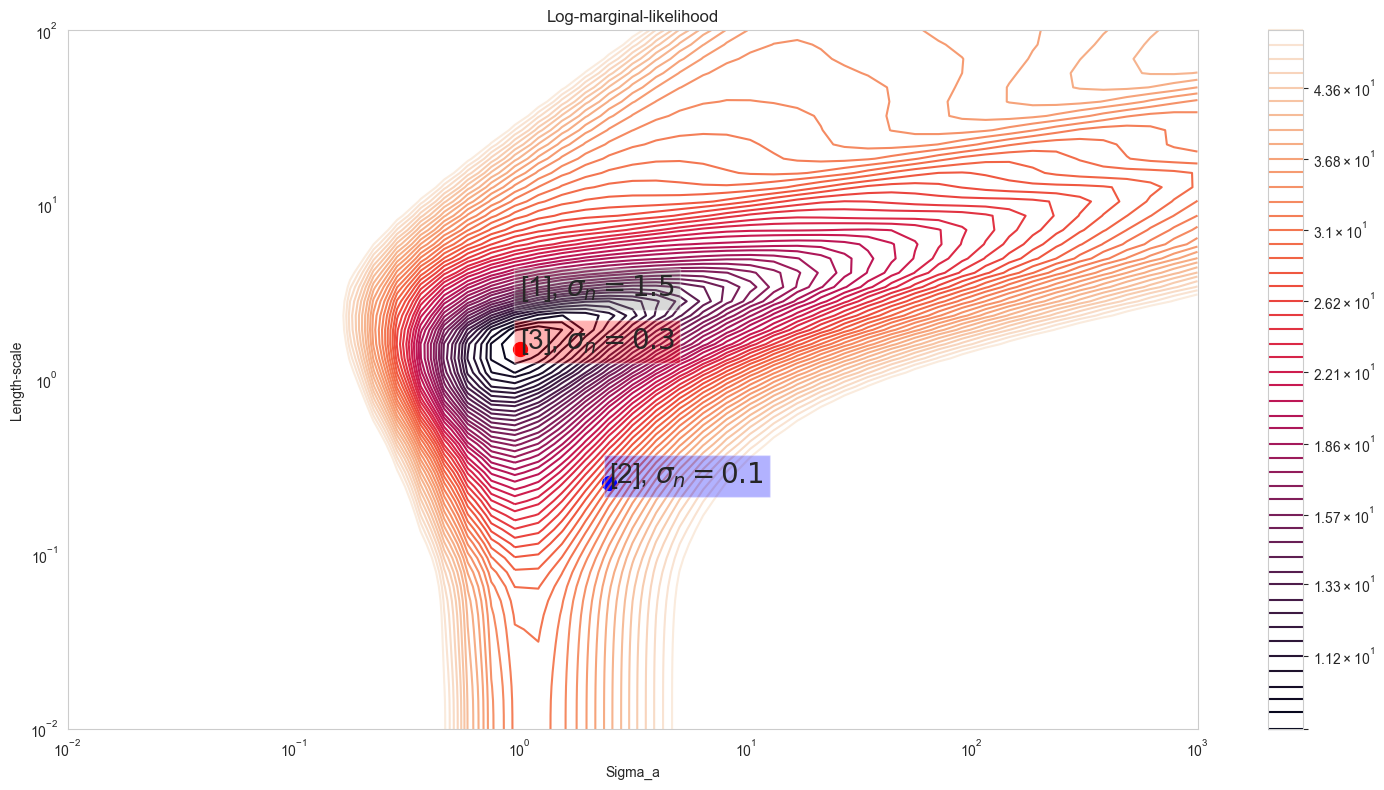

In [32]:
# Plot the Landscape of the marginal likelihood w.r.t. the two hyperparamters in the RBF Kernel
# Source-code: https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_noisy.html
from matplotlib.colors import LogNorm
# Plot LML landscape
fig, ax = plt.subplots(figsize=(15, 8))

# from 0.01 to 1000, correspnds to sigma_a 
theta0 = np.logspace(-2, 3, 49)
# from 0.01 to 10, corresponds to length-scale
theta1 = np.logspace(-2, 2, 50)
Theta0, Theta1 = np.meshgrid(theta0, theta1)

LML = [[log_marginallikelihood(x,y,exponential_cov,[Theta0[i, j], Theta1[i, j], params3[2]]) 
       for i in range(Theta0.shape[0])] for j in range(Theta0.shape[1])]
LML = np.array(LML).T.reshape(50,49)

vmin, vmax = (-LML).min(), (-LML).max()
vmax = 50
level = np.around(np.logspace(np.log10(vmin), np.log10(vmax), 50), decimals=1)
h = ax.contour(Theta0, Theta1, -LML,
            levels=level, norm=LogNorm(vmin=vmin, vmax=vmax))
fig.colorbar(h)
ax.grid()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Length-scale")
ax.set_xlabel("Sigma_a")
ax.set_title("Log-marginal-likelihood")

# parameter sets
ax.scatter(params1[0],params1[1],s=100,c='gray')
ax.text(params1[0],params1[1], 
        "[1], $\sigma_n={}$".format(params1[2]),
        fontsize=20,
        bbox=dict(facecolor='gray',alpha=0.3))
ax.scatter(params2[0],params2[1],s=100,c='blue')
ax.text(params2[0],params2[1], 
        "[2], $\sigma_n={}$".format(params2[2]),
        fontsize=20,
        bbox=dict(facecolor='blue', alpha=0.3))
ax.scatter(params3[0],params3[1],s=100,c='red')
ax.text(params3[0],params3[1],
        "[3], $\sigma_n={}$".format(params3[2]),
        fontsize=20,
        bbox=dict(facecolor='red', alpha=0.3))

plt.tight_layout()

plt.show()

As function of $\sigma_a$ and the length-scale we see there's a optima where model 3 is located.

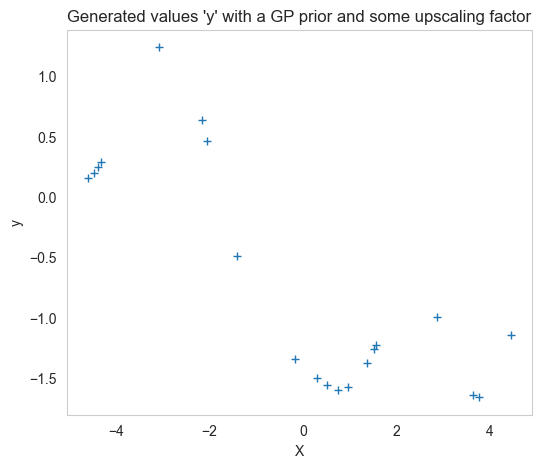

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 5))
ax.set_ylabel("y")
ax.set_xlabel("X")
ax.set_title("Generated values 'y' with a GP prior and some upscaling factor")
ax.grid()
ax.plot(x,y, '+')